# State Preparation via Alias Sampling

Gates for preparing coefficient states.

In section III.D. of the [Linear T paper](https://arxiv.org/abs/1805.03662) the authors introduce
a technique for initializing a state with $L$ unique coefficients (provided by a classical
database) with a number of T gates scaling as 4L + O(log(1/eps)) where eps is the
largest absolute error that one can tolerate in the prepared amplitudes.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `StatePreparationAliasSampling`
Initialize a state with $L$ unique coefficients using coherent alias sampling.

In particular, we take the zero state to:

$$
\sum_{\ell=0}^{L-1} \sqrt{p_\ell} |\ell\rangle |\mathrm{temp}_\ell\rangle
$$

where the probabilities $p_\ell$ are $\mu$-bit binary approximations to the true values and
where the temporary register must be treated with care, see the details in Section III.D. of
the reference.

The preparation is equivalent to [classical alias sampling]
(https://en.wikipedia.org/wiki/Alias_method): we sample `l` with probability `p[l]` by first
selecting `l` uniformly at random and then returning it with probability `keep[l] / 2**mu`;
otherwise returning `alt[l]`.

Signature:
    selection: The input/output register $|\ell\rangle$ of size lg(L) where the desired
        coefficient state is prepared.
    temp: Work space comprised of sub signature:
        - sigma: A mu-sized register containing uniform probabilities for comparison against
            `keep`.
        - alt: A lg(L)-sized register of alternate indices
        - keep: a mu-sized register of probabilities of keeping the initially sampled index.
        - one bit for the result of the comparison.

This gate corresponds to the following operations:
 - UNIFORM_L on the selection register
 - H^mu on the sigma register
 - QROM addressed by the selection register into the alt and keep signature.
 - LessThanEqualGate comparing the keep and sigma signature.
 - Coherent swap between the selection register and alt register if the comparison
   returns True.

Total space will be (2 * log(L) + 2 mu + 1) work qubits + log(L) ancillas for QROM.
The 1 ancilla in work qubits is for the `LessThanEqualGate` followed by coherent swap.

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Babbush et. al. (2018). Section III.D. and Figure 11.


In [2]:
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling

### Example Instances

In [3]:
coeffs = np.array([1.0, 1, 3, 2])
mu = 3
state_prep_alias = StatePreparationAliasSampling.from_lcu_probs(
    coeffs, probability_epsilon=2**-mu / len(coeffs)
)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([state_prep_alias],
           ['`state_prep_alias`'])

### Call Graph

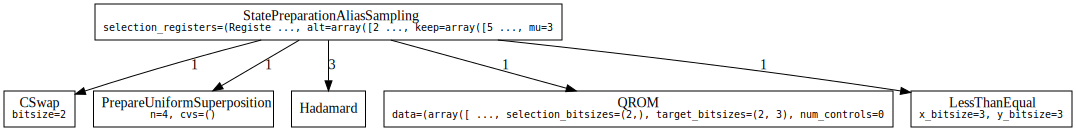

#### Counts totals:
 - `CSwap(bitsize=2)`: 1
 - `Hadamard()`: 3
 - `LessThanEqual(x_bitsize=3, y_bitsize=3)`: 1
 - `PrepareUniformSuperposition(n=4, cvs=())`: 1
 - `QROM(data=(array([2, 2, 3, 3]), array([5, 4, 7, 0])), selection_bitsizes=(2,), target_bitsizes=(2, 3), num_controls=0)`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
state_prep_alias_g, state_prep_alias_sigma = state_prep_alias.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(state_prep_alias_g)
show_counts_sigma(state_prep_alias_sigma)